In [1]:
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
dr = pd.read_csv("https://ztf.snad.space/dr23/csv/805205100020986?min_mjd=58476&max_mjd=58477")
dr

,oid,filter,mjd,mag,magerr,clrcoeff,ref,ref_err
0,805205100020986,zr,58476.11376,19.086643,0.054744,0.071409,19.164,0.026
1,805205100020986,zr,58476.11471,19.133429,0.056634,0.071332,19.164,0.026
2,805205100020986,zr,58476.11567,19.167086,0.058039,0.068875,19.164,0.026
3,805205100020986,zr,58476.11662,19.211674,0.059960,0.072751,19.164,0.026
4,805205100020986,zr,58476.11758,19.078976,0.054441,0.075371,19.164,0.026
...,...,...,...,...,...,...,...,...
114,805205100020986,zr,58476.25522,19.066612,0.053956,0.071784,19.164,0.026
115,805205100020986,zr,58476.25617,19.149880,0.057316,0.073786,19.164,0.026
116,805205100020986,zr,58476.25713,19.197788,0.059354,0.065788,19.164,0.026
117,805205100020986,zr,58476.25808,19.169525,0.058142,0.081643,19.164,0.026


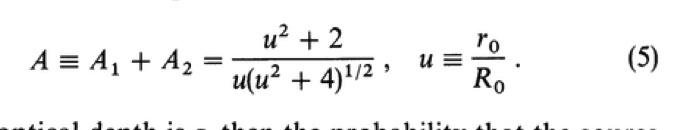

https://articles.adsabs.harvard.edu/pdf/1986ApJ...304....1P

Reduced χ² = 1.16
Fitted parameters (with 1σ uncertainties):
t0     = 58476.22000 ± 0.00028
u0     = 0.800 ± 0.020
tE     = 0.00799 ± 0.00046
m_base = 19.126 ± 0.007


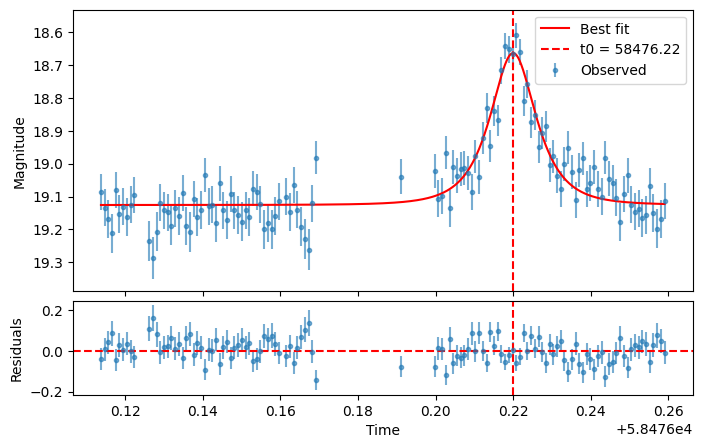

In [3]:
# Paczynski amplification model → converted to magnitudes
def microlens_mag_model(t, t0, u0, tE, m_base):
    u = np.sqrt(u0**2 + ((t - t0) / tE)**2)
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    return m_base - 2.5 * np.log10(A)


t_obs = dr["mjd"]
mag_obs = dr['mag']
mag_err = dr['magerr']

# Fit the model to magnitude data
p0 = [np.mean(t_obs), 0.2, 0.1, np.max(mag_obs)]
popt, pcov = curve_fit(
    microlens_mag_model,
    t_obs,
    mag_obs,
    sigma=mag_err,
    absolute_sigma=True,
    p0=p0,
    bounds=[(-np.inf, -np.inf, 0.0, -np.inf), (np.inf, np.inf, np.inf, np.inf)],
)

t0_fit, u0_fit, tE_fit, m_base_fit = popt
perr = np.sqrt(np.diag(pcov))

# Compute model and residuals
t_ = np.linspace(t_obs.min(), t_obs.max(), 1001)
mag_fit = microlens_mag_model(t_, *popt)
residuals = mag_obs - microlens_mag_model(t_obs, *popt)

chi2 = np.sum((residuals / mag_err) ** 2)
dof = len(mag_obs) - len(popt)
chi2_red = chi2 / dof
print(f"Reduced χ² = {chi2_red:.2f}")

# Output fit results
print("Fitted parameters (with 1σ uncertainties):")
print(f"t0     = {t0_fit:.5f} ± {perr[0]:.5f}")
print(f"u0     = {u0_fit:.3f} ± {perr[1]:.3f}")
print(f"tE     = {tE_fit:.5f} ± {perr[2]:.5f}")
print(f"m_base = {m_base_fit:.3f} ± {perr[3]:.3f}")

# Plot with residuals
fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 5),
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)


# Light curve
ax1.errorbar(t_obs, mag_obs, yerr=mag_err, fmt='o', ms=3, label='Observed', alpha=0.6)
ax1.plot(t_, mag_fit, 'r-', label='Best fit')
ax1.axvline(t0_fit, color='r', linestyle='--', label=f't0 = {t0_fit:.2f}')
ax1.invert_yaxis()
ax1.set_ylabel("Magnitude")
ax1.legend()

# Residuals
ax2.errorbar(t_obs, residuals, yerr=mag_err, fmt='o', ms=3, alpha=0.6)
ax2.axhline(0, color='r', ls='--')
ax2.axvline(t0_fit, color='r', linestyle='--')
ax2.set_xlabel("Time")
ax2.set_ylabel("Residuals")

plt.show()

In [4]:
import lsdb

zuber = lsdb.read_hats(
    "https://data.lsdb.io/hats/ztf_dr16/zubercal",
    search_filter=lsdb.ConeSearch(ra=1.6191310925, dec=54.08183605141, radius_arcsec=0.2),
    filters=[
        ("mjd", ">", 58476.0),
        ("mjd", "<", 58477.0),
        ("magerr", "<", 1000),
        ("info", "==", 0),
        ("flag", "==", 0),
    ]
).compute()
zuber

,mjd,mag,objdec,objra,magerr,objectid,info,flag,rcidin,fieldid,band,Norder,Dir,Npix
_healpix_29,,,,,,,,,,,,,,
210140932403609003,58476.23228,19.2302,54.081829,1.61918,588,172890016191138921,0,0,16,805,r,7,10000,11945
210140932404324882,58476.127148,19.426001,54.081841,1.61918,656,172890016191138921,0,0,16,805,r,7,10000,11945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210140932426729621,58476.129057,19.2703,54.08186,1.61914,643,172890016191138921,0,0,16,805,r,7,10000,11945
210140932426842217,58476.159646,19.2619,54.081879,1.61912,630,172890016191138921,0,0,16,805,r,7,10000,11945


Reduced χ² = 0.92
Fitted parameters (with 1σ uncertainties):
t0     = 58476.21993 ± 0.00031
u0     = 0.796 ± 0.021
tE     = 0.00796 ± 0.00050
m_base = 19.275 ± 0.007


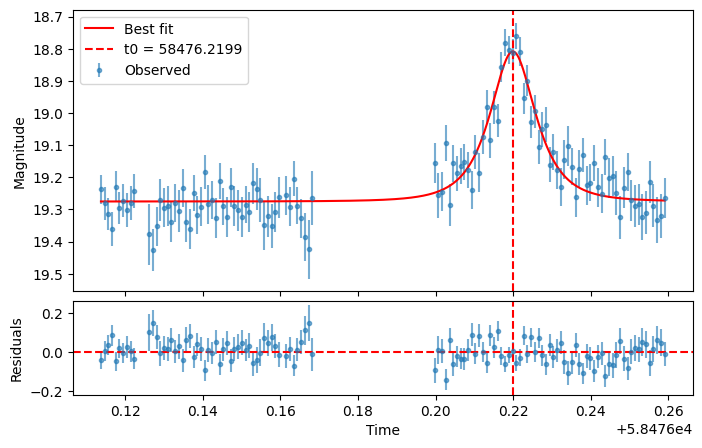

In [5]:
t_obs = zuber["mjd"]
mag_obs = zuber['mag']
mag_err = zuber['magerr'] / 1e4

# Fit the model to magnitude data
p0 = [np.mean(t_obs), 0.2, 0.1, np.max(mag_obs)]
popt, pcov = curve_fit(
    microlens_mag_model,
    t_obs,
    mag_obs,
    sigma=mag_err,
    absolute_sigma=True,
    p0=p0,
    bounds=[(-np.inf, -np.inf, 0.0, -np.inf), (np.inf, np.inf, np.inf, np.inf)],
)

t0_fit, u0_fit, tE_fit, m_base_fit = popt
perr = np.sqrt(np.diag(pcov))

# Compute model and residuals
t_ = np.linspace(t_obs.min(), t_obs.max(), 1001)
mag_fit = microlens_mag_model(t_, *popt)
residuals = mag_obs - microlens_mag_model(t_obs, *popt)

chi2 = np.sum((residuals / mag_err) ** 2)
dof = len(mag_obs) - len(popt)
chi2_red = chi2 / dof
print(f"Reduced χ² = {chi2_red:.2f}")

# Output fit results
print("Fitted parameters (with 1σ uncertainties):")
print(f"t0     = {t0_fit:.5f} ± {perr[0]:.5f}")
print(f"u0     = {u0_fit:.3f} ± {perr[1]:.3f}")
print(f"tE     = {tE_fit:.5f} ± {perr[2]:.5f}")
print(f"m_base = {m_base_fit:.3f} ± {perr[3]:.3f}")

# Plot with residuals
fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 5),
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)


# Light curve
ax1.errorbar(t_obs, mag_obs, yerr=mag_err, fmt='o', ms=3, label='Observed', alpha=0.6)
ax1.plot(t_, mag_fit, 'r-', label='Best fit')
ax1.axvline(t0_fit, color='r', linestyle='--', label=f't0 = {t0_fit:.4f}')
ax1.invert_yaxis()
ax1.set_ylabel("Magnitude")
ax1.legend()

# Residuals
ax2.errorbar(t_obs, residuals, yerr=mag_err, fmt='o', ms=3, alpha=0.6)
ax2.axhline(0, color='r', ls='--')
ax2.axvline(t0_fit, color='r', linestyle='--')
ax2.set_xlabel("Time")
ax2.set_ylabel("Residuals")

plt.show()

In [6]:
forced_data = b"""# ------------------------------------------------------------------
# Generated by forcedphotometry_trim.pl, v3.8 on 2025-04-15 at 11:27:47
#
# Requested input R.A. = 1.6191310925 degrees
# Requested input Dec. = 54.08183605141 degrees
# Requested JD start = 2458476.5 days
# Requested JD end = 2458477.5 days
# Authenticated program IDs = 1
#
# Column definitions:
# index = sequential counter
# field = ZTF Field identifier
# ccdid = CCD identifier (1..16)
# qid = Quadrant (CCD-amplifier) identifier (0..3)
# filter = Filter string: ZTF_g, ZTF_r, ZTF_i
# pid = processed image Operations DB identifier
# infobitssci = processing summary/QA bits for sci image
# sciinpseeing = Effective FWHM of sci image [pixels]
# scibckgnd = Background level in sci image [DN]
# scisigpix = Robust sigma per pixel in sci image [DN]
# zpmaginpsci = Photometric zeropoint for sci image [mag]
# zpmaginpsciunc = 1-sigma uncertainty in zpmaginpsci [mag]
# zpmaginpscirms = RMS (deviation from average) in difference between instrumental mags and PS1 calibrators [mag]
# clrcoeff = Linear color coefficient from calibration; for ZTF_g,r,i, PS1 color used is g-r, g-r, r-i respectively
# clrcoeffunc = 1-sigma uncertainty in clrcoeff
# ncalmatches = Number of PS1 calibrators used in initial calibration of sci image
# exptime = Integration time for sci image [sec]
# adpctdif1 = Full sci image astrometric RMS along R.A. with respect to Gaia1 [arcsec]
# adpctdif2 = Full sci image astrometric RMS along Dec. with respect to Gaia1 [arcsec]
# diffmaglim = Magnitude limit in difference image [mag]
# zpdiff = Photometric zeropoint for difference image [mag]
# programid = Program identifier [0=engineering; 1=public; 2=private; 3=Caltech time]
# jd = Julian Date at start of exposure [days]
# rfid = Rerence image Operations DB identifier
# forcediffimflux = Forced difference image PSF-fit flux [DN]
# forcediffimfluxunc = 1-sigma uncertainty in forcediffimflux [DN]
# forcediffimsnr = Signal-to-noise ratio for forcediffimflux measurement
# forcediffimchisq = Reduced chi-square in PSF-fit
# forcediffimfluxap = Forced difference image aperture flux using a fixed 9-pixel diameter aperture [DN]
# forcediffimfluxuncap = 1-sigma uncertainty in forcediffimfluxap [DN]
# forcediffimsnrap = Signal-to-noise ratio for forcediffimfluxap measurement
# aperturecorr = Aperture (curve-of-growth) correction factor that was applied to forcediffimfluxap measurement
# dnearestrefsrc = Distance to nearest ref image source if found within 5 arcsec [arcsec]
# nearestrefmag = Magnitude of nearest ref image source [mag]
# nearestrefmagunc = 1-sigma uncertainty in nearestrefmag [mag]
# nearestrefchi = Chi parameter for nearestrefmag measurement (ratio: RMS in PSF-fit residuals / expected RMS from priors)
# nearestrefsharp = Sharp parameter for nearestrefmag measurement (~0 => PSF like; >>0 => extended; <<0 => pixel spike or hard edge)
# refjdstart = JD of earliest sci image used for ref image [days]
# refjdend = JD of latest sci image used for ref image [days]
# procstatus = Per-epoch processing status codes (0 => no warnings); if non-zero, see accompanying log file and document link below
#
# Documentation: https://irsa.ipac.caltech.edu/data/ZTF/docs/forcedphot.pdf
#
# ------------------------------------------------------------------
# Order of columns below:
 index, field, ccdid, qid, filter, pid, infobitssci, sciinpseeing, scibckgnd, scisigpix, zpmaginpsci, zpmaginpsciunc, zpmaginpscirms, clrcoeff, clrcoeffunc, ncalmatches, exptime, adpctdif1, adpctdif2, diffmaglim, zpdiff, programid, jd, rfid, forcediffimflux, forcediffimfluxunc, forcediffimsnr, forcediffimchisq, forcediffimfluxap, forcediffimfluxuncap, forcediffimsnrap, aperturecorr, dnearestrefsrc, nearestrefmag, nearestrefmagunc, nearestrefchi, nearestrefsharp, refjdstart, refjdend, procstatus
#
 0 805 5 0 ZTF_r 722111781615 0 1.6039 294.951 9.20216 26.2487 2.5257e-06 0.0166024 0.0714093 6.58356e-06 2023 30. 0.038176 0.044893 20.3708 26.2487 2 2458476.6117824 805120216 22.2745729851068 24.9193611044942 0.994322540815567 1.62121884078881 55.2137334175686 49.3082017834404 1.12730943490867 1.03476040238482 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 1 805 5 0 ZTF_r 722112731615 0 1.5696 297.337 9.30426 26.2464 2.6372e-06 0.0169085 0.071332 6.87182e-06 2024 30. 0.041422 0.049579 20.3604 26.2464 2 2458476.6127315 805120216 20.5117722525759 28.169084954433 0.810000426027826 1.2341649908994 54.4270259687679 54.7259191453914 1.00123663477538 1.03975032603853 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 2 805 5 0 ZTF_r 722113691615 0 1.472 295.899 9.40341 26.245 3.0835e-06 0.0182765 0.068875 8.05501e-06 2022 30. 0.051691 0.056882 20.3799 26.245 2 2458476.6136921 805120216 -9.09964798307047 27.9887000534114 -0.36165682496522 1.20785338019149 32.2717342010306 55.4098145525851 0.586341723933996 1.03548595633498 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 3 805 5 0 ZTF_r 722114641615 0 1.6513 296.263 9.52778 26.2425 2.3811e-06 0.016132 0.0727514 6.21203e-06 2024 30. 0.035094 0.049105 20.3086 26.2425 2 2458476.6146412 805120216 -36.1404777530065 29.6580327406288 -1.35552131217244 1.37812804560029 30.243451976992 58.5997374633022 0.519578153147506 1.03415563308342 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 4 805 5 0 ZTF_r 722115601615 0 1.5749 293.876 9.65399 26.2421 2.5033e-06 0.0165193 0.0753711 6.53307e-06 2027 30. 0.038107 0.051078 20.3194 26.2421 2 2458476.6156019 805120216 54.7722790618484 27.9747288743621 2.17795913665735 1.28083321852173 66.8070028776831 54.9786201527166 1.22332920868106 1.0346905149051 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 5 805 5 0 ZTF_r 722116551615 0 1.5418 294.811 9.70236 26.2409 3.7051e-06 0.0200629 0.0666866 9.66803e-06 2019 30. 0.038704 0.060075 20.3157 26.2409 2 2458476.6165509 805120216 5.34207879770817 25.2559465293526 0.235288901113737 1.36699120605524 56.3826657014662 49.8194783262335 1.13936171365021 1.03392396826676 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 6 805 5 0 ZTF_r 722117511615 0 1.5489 295.388 9.94404 26.24 2.5819e-06 0.0168375 0.0704686 6.7246e-06 2027 30. 0.036904 0.056053 20.2852 26.24 2 2458476.6175116 805120216 20.1795777975867 30.2166838617664 0.742882411005402 1.2918293761989 120.535846380447 60.2267626112533 2.01484617435114 1.03364408947075 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 7 805 5 0 ZTF_r 722118471615 0 1.6412 294.189 10.0192 26.2486 2.5031e-06 0.0165301 0.0667325 6.52707e-06 2022 30. 0.034047 0.05028 20.255 26.2486 2 2458476.6184722 805120216 0.154148321784272 28.7818872041257 0.00595764107582373 1.3511527062519 75.1537633851404 56.8039241359566 1.33194897106786 1.03542970355135 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 8 805 5 0 ZTF_r 722119421615 0 1.5872 296.841 10.0513 26.2396 1.8498e-06 0.014252 0.0785104 4.80707e-06 2029 30. 0.035761 0.048631 20.2613 26.2396 2 2458476.6194213 805120216 -7.22296887317411 30.8572694445936 -0.26038325494104 1.41433130955446 -72.3656499192357 60.6478532449695 -1.20124675214346 1.03675787967811 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 9 805 5 0 ZTF_r 722120381615 0 1.6861 297.538 10.222 26.2448 1.8287e-06 0.013996 0.0742816 4.77311e-06 2006 30. 0.033251 0.043176 20.2166 26.2448 2 2458476.6203819 805120216 44.1248666953008 31.0883397358342 1.57884929734352 1.10292997468471 139.081395500343 60.5405072485514 2.31280052091772 1.03892056709913 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 10 805 5 0 ZTF_r 722121331615 0 1.6935 92.5167 25.2318 25.1063 0.000341055 0.193748 0.17644 0.00088621 2008 30. 0.035111 0.047507 17.8985 25.1063 2 2458476.621331 805120216 -28.2016432093502 88.2372369288256 -0.355530869398392 0.985748961561273 -454.350283336096 170.998275701139 -2.67494135107422 1.04823736848041 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 11 805 5 0 ZTF_r 722122291615 0 1.7344 209.326 13.9342 25.8934 5.3249e-06 0.024272 0.0935183 1.38345e-05 2028 30. 0.034471 0.04406 19.4349 25.8934 2 2458476.6222917 805120216 18.6298726176546 49.244260280545 0.420832302623394 0.993341463078979 -37.7429924117857 95.6912126747925 -0.397081326227441 1.04014352512667 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 12 805 5 0 ZTF_r 722123251615 0 1.7384 264.298 13.4095 26.1303 6.3386e-06 0.0262579 0.0555364 1.65389e-05 2021 30. 0.031583 0.042495 19.6625 26.1303 2 2458476.6232523 805120216 127.173861461017 44.7012408529847 3.16470388760649 1.42476249893509 321.660671766654 86.7628802043316 3.7323227875226 1.03881469853594 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 13 805 5 0 ZTF_r 722124201615 0 1.7582 253.02 14.2046 26.0823 3.9327e-06 0.0207081 0.0671481 1.02658e-05 2025 30. 0.033344 0.041706 19.6572 26.0823 2 2458476.6242014 805120216 -36.8928955395247 46.8376758617191 -0.876197897081757 1.10971009590002 -52.3674257289518 89.7131035388773 -0.587652430632332 1.04356192676796 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 14 805 5 0 ZTF_r 722125161615 0 1.6417 289 11.5154 26.2224 2.2445e-06 0.0156252 0.0676889 5.86071e-06 2025 30. 0.033861 0.0424 20.0596 26.2224 2 2458476.625162 805120216 -116.732180453633 32.9172187464205 -3.94477525627181 1.43952439242129 -181.753377373254 64.2961583912301 -2.8458542688296 1.03866471026959 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 15 805 5 0 ZTF_r 722126111615 0 1.7506 293.711 10.7 26.2425 1.6103e-06 0.0133021 0.0726991 4.19399e-06 2029 30. 0.03206 0.038192 20.133 26.2425 2 2458476.6261111 805120216 -16.1874549425607 35.6901397210223 -0.504527828133334 1.17669391003146 84.5492153998796 69.7517536217661 1.22030852000784 1.03830154883878 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 16 805 5 0 ZTF_r 722127071615 0 2.0533 294.435 10.8082 26.2421 1.5298e-06 0.0129307 0.0756381 3.98824e-06 2029 30. 0.036793 0.039292 19.9892 26.2421 2 2458476.6270718 805120216 -0.900239368446055 36.6058735548301 -0.0273565941233209 1.00979098398181 -48.5195196860069 67.3108399609037 -0.725682541935737 1.0467154375625 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 17 805 5 0 ZTF_r 722128031615 0 1.8795 290.77 10.8664 26.2294 1.5874e-06 0.0131116 0.0755363 4.14788e-06 2033 30. 0.03461 0.037358 20.0685 26.2294 2 2458476.6280324 805120216 24.9538764701745 33.1570004363302 0.837177575627563 1.12980208024476 9.90027498855886 61.9434758376936 0.160904014110122 1.04705017287839 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 18 805 5 0 ZTF_r 722128981615 0 1.8161 289.231 11.0051 26.227 1.8107e-06 0.0140849 0.0697902 4.71542e-06 2031 30. 0.034591 0.038181 20.0592 26.227 2 2458476.6289815 805120216 36.6510235052855 34.624611385628 1.17748667320436 1.26696748057138 187.142959444832 66.2822392773083 2.84244135530354 1.04105670052029 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 19 805 5 0 ZTF_r 722129941615 0 1.8288 290.184 10.8748 26.2274 1.7553e-06 0.0137941 0.0726936 4.58122e-06 2030 30. 0.033523 0.040275 20.0856 26.2274 2 2458476.6299421 805120216 -4.9188458158122 35.7489083561283 -0.153057715229195 1.18436690904898 -34.9814813519894 67.9522534605415 -0.518262189229695 1.04495132148167 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 20 805 5 0 ZTF_r 722130891615 0 1.6827 290.79 10.8718 26.2206 1.66e-06 0.0135334 0.0723475 4.31843e-06 2036 30. 0.032687 0.042442 20.1174 26.2206 2 2458476.6308912 805120216 37.1712545685711 33.3484656864249 1.23989858068311 1.18720445834249 -21.877599885094 64.6499690717958 -0.340679927543143 1.03951375004207 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 21 805 5 0 ZTF_r 722131851615 0 1.7177 279.129 11.5555 26.185 1.6142e-06 0.0133772 0.0735673 4.19889e-06 2036 30. 0.032273 0.044279 19.984 26.185 2 2458476.6318519 805120216 -28.6629992146136 35.8677424395304 -0.888939880471814 1.42524970956102 -104.424952607941 69.9904463619941 -1.50203729417736 1.03796781325475 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 22 805 5 0 ZTF_r 722132811615 0 1.5823 280.19 11.5012 26.1802 2.218e-06 0.0155309 0.0711561 5.78985e-06 2031 30. 0.03695 0.045399 20.0494 26.1802 2 2458476.6328125 805120216 36.6408254552094 34.7216164785635 1.17387029912966 1.44872994661876 60.9625837147515 68.6289027826753 0.894275847858084 1.03658139386316 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 23 805 5 0 ZTF_r 722133761615 0 1.6117 287.794 11.1463 26.2063 1.5736e-06 0.0131298 0.0757239 4.09269e-06 2032 30. 0.032355 0.04369 20.0982 26.2063 2 2458476.6337616 805120216 -57.4437430699557 33.9964849403246 -1.87959169134535 1.12943775741891 -150.979469111877 67.1266367656105 -2.26432206120603 1.03705954083745 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 24 805 5 0 ZTF_r 722134721615 0 1.6893 286.275 10.8327 26.2124 1.5944e-06 0.013193 0.0771929 4.16011e-06 2033 30. 0.033907 0.039582 20.1108 26.2124 2 2458476.6347222 805120216 -66.5995999391827 33.2256602692549 -2.22973269153955 1.47490905770572 -126.026340564994 64.7918699631222 -1.95819529968539 1.03848816318936 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 25 805 5 0 ZTF_r 722135671615 0 1.6644 288.505 10.9056 26.2258 2.3183e-06 0.0158335 0.0673846 6.06121e-06 2028 30. 0.034944 0.041888 20.1244 26.2258 2 2458476.6356713 805120216 31.5501475499886 32.3174801417302 1.08597219326641 1.10930168732994 8.89364085940282 63.2605892043554 0.141534249916048 1.03767812410061 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 26 805 5 0 ZTF_r 722136631615 0 1.6783 294.784 10.6637 26.2327 1.6436e-06 0.0133765 0.0774189 4.29175e-06 2030 30. 0.035484 0.041885 20.1509 26.2327 2 2458476.6366319 805120216 1.85027173182239 32.4418147952403 0.0634432137417532 1.13201514962364 77.0855096448166 62.8129756190846 1.23548811726416 1.03966268277268 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 27 805 5 0 ZTF_r 722137581615 0 1.8867 294.503 10.6848 26.2429 1.495e-06 0.0127004 0.0755182 3.90613e-06 2031 30. 0.034624 0.03661 20.0756 26.2429 2 2458476.637581 805120216 14.310634913858 36.5557677753731 0.435469551112871 1.07340653933934 -9.92467984808719 68.3933546626589 -0.146089092824317 1.04778118123025 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 28 805 5 0 ZTF_r 722138541615 0 1.8476 295.146 10.6414 26.247 1.6008e-06 0.0131311 0.0731489 4.18943e-06 2030 30. 0.034318 0.043354 20.0788 26.247 2 2458476.6385417 805120216 83.3670914291252 39.5338234887811 2.345744096342 0.934408472725192 -3.54048096635254 75.0294458934435 -0.0475056994879612 1.03868277964054 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 29 805 5 0 ZTF_r 722139501615 0 1.8858 295.356 10.7755 26.2452 1.5606e-06 0.0130425 0.0772676 4.07391e-06 2035 30. 0.033957 0.038941 20.1041 26.2452 2 2458476.6395023 805120216 34.246166442407 36.6669815513515 1.03894271970648 1.12090273469322 30.5838990216104 69.0571207199668 0.445861093253782 1.04827711327864 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 30 805 5 0 ZTF_r 722140451615 0 1.8296 295.032 10.7743 26.2494 1.7999e-06 0.0140392 0.0680286 4.69956e-06 2032 30. 0.03382 0.037119 20.0993 26.2494 2 2458476.6404514 805120216 2.06120118681139 37.6480157034389 0.0609022158202144 1.2465208866601 -139.998512201023 71.7506376450321 -1.96432275532895 1.04109740921198 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 31 805 5 0 ZTF_r 722141411615 0 1.8066 292.934 10.7988 26.2508 2.0991e-06 0.0152084 0.0697004 5.47243e-06 2029 30. 0.033724 0.039925 20.1079 26.2508 2 2458476.641412 805120216 25.9465859883229 33.7848636731671 0.854304811644546 1.39641173869838 114.763438026847 64.6357150669384 1.78750055236814 1.04305278105281 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 32 805 5 0 ZTF_r 722142361615 0 1.7966 294.648 10.8473 26.2413 1.6539e-06 0.0134499 0.0775673 4.31485e-06 2033 30. 0.03373 0.040525 20.1098 26.2413 2 2458476.6423611 805120216 49.7605166549023 35.4100026926214 1.56319703355036 1.18133112904313 43.663048300507 67.1403528154996 0.654704951636965 1.04677912473582 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 33 805 5 0 ZTF_r 722143321615 0 1.6901 294.837 10.8339 26.2461 1.8781e-06 0.0142796 0.0719731 4.90875e-06 2031 30. 0.033336 0.04126 20.1478 26.2461 2 2458476.6433218 805120216 -11.3795997708489 37.041548330314 -0.34173751505372 1.08861862695803 -10.5819258418162 70.7519846213436 -0.150570980845352 1.0460365510025 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 34 805 5 0 ZTF_r 722144271615 0 1.7751 294.028 10.8841 26.2402 1.4522e-06 0.0125291 0.0773128 3.79683e-06 2033 30. 0.033765 0.037988 20.1022 26.2402 2 2458476.6442708 805120216 5.77949551807706 34.3332891671897 0.187253231431306 1.13749947347396 -1.235926389192 65.4527977956397 -0.0190098890564921 1.04947369045832 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 35 805 5 0 ZTF_r 722145231615 0 1.774 287.954 11.348 26.2224 2.2326e-06 0.0155651 0.0700316 5.83941e-06 2027 30. 0.03404 0.039822 20.0474 26.2224 2 2458476.6452315 805120216 40.5653134118431 38.3637033593732 1.17622149742257 1.29174150140546 62.3409952045891 73.313648183883 0.856059778073799 1.04724538010931 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 36 805 5 0 ZTF_r 722146191615 0 1.7453 293.064 11.2077 26.2267 1.9357e-06 0.0145173 0.0741986 5.05533e-06 2028 30. 0.034561 0.04262 20.0906 26.2267 2 2458476.6461921 805120216 -33.4856262867119 35.4872438352688 -1.04964141135255 1.42386323104858 -162.100033751163 67.7555094323776 -2.4085389981129 1.04667617782667 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 37 805 5 0 ZTF_r 722147141615 0 1.7758 287.661 11.3687 26.223 1.7586e-06 0.0138178 0.0733539 4.59425e-06 2028 30. 0.033318 0.040419 20.0162 26.223 2 2458476.6471412 805120216 -8.87288626336901 37.4812741055438 -0.263333050535842 1.18218781811274 -53.778182020711 72.3652376834153 -0.748154540825217 1.04132331664149 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 38 805 5 0 ZTF_r 722148101615 0 1.7602 291.893 11.5468 26.2334 2.4229e-06 0.0162407 0.0689764 6.33421e-06 2029 30. 0.034107 0.039403 20.0417 26.2334 2 2458476.6481019 805120216 -18.4211103595112 37.5645279728548 -0.545497380608034 1.19203203674981 31.8969318988867 73.384404063313 0.437582889447574 1.03847944208887 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 39 805 5 0 ZTF_r 722149051615 0 1.5708 290.116 11.2687 26.2204 2.4845e-06 0.0164415 0.0691612 6.49444e-06 2028 30. 0.035035 0.053205 20.1332 26.2204 2 2458476.6490509 805120216 11.1142854899514 33.0668725219193 0.373889464902 1.28788948277482 -60.3365242573337 65.6573198482039 -0.925150377141459 1.03484666581306 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 40 805 5 0 ZTF_r 722150011615 0 1.6626 281.221 11.8822 26.1938 2.052e-06 0.014972 0.0701879 5.35679e-06 2030 30. 0.034549 0.043733 20.0031 26.1938 2 2458476.6500116 805120216 -39.6670807500082 39.18047722972 -1.12619947318742 1.25326725079444 -202.166141577186 77.4932489907248 -2.62639319970542 1.03598205730827 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 41 805 5 0 ZTF_r 722150971615 0 1.7197 274.86 12.2859 26.17 2.33e-06 0.0158802 0.0697993 6.10065e-06 2028 30. 0.033727 0.044308 19.9126 26.17 2 2458476.6509722 805120216 31.625991235451 37.7124098004702 0.932856115316452 1.06808579995905 39.3588254662061 74.1000287334373 0.53473541235413 1.03652449502314 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 42 805 5 0 ZTF_r 722151921615 0 1.7043 277.118 12.0784 26.1864 1.8626e-06 0.0142031 0.0765171 4.8801e-06 2031 30. 0.034633 0.04216 19.9597 26.1864 2 2458476.6519213 805120216 21.825801553641 36.897511271762 0.658003084068322 1.16101918452045 180.114232553068 72.7779948187559 2.49151289100148 1.0401041571482 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 43 805 5 0 ZTF_r 722152881615 0 1.7497 277.891 12.1643 26.1831 1.9506e-06 0.0145343 0.0722365 5.09373e-06 2027 30. 0.034379 0.040422 19.9482 26.1831 2 2458476.6528819 805120216 52.2105946424748 39.1323328949611 1.48414967487361 1.26413127455953 225.795888199178 75.4520970034944 3.01272788331936 1.04896110488548 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 44 805 5 0 ZTF_r 722153841615 0 1.8555 282.007 12.096 26.1968 1.8467e-06 0.014234 0.0712701 4.82424e-06 2032 30. 0.035432 0.043243 19.8878 26.1968 2 2458476.6538426 805120216 -22.474629317661 44.390199671686 -0.563196879758776 1.17966658888151 -71.3983564515391 83.7142472772217 -0.858625990533109 1.04784026657987 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 45 805 5 0 ZTF_r 722154791615 0 1.6608 287.187 11.7286 26.2068 2.4999e-06 0.0165661 0.0692508 6.51901e-06 2032 30. 0.034355 0.043541 20.036 26.2068 2 2458476.6547917 805120216 -32.198704225725 34.8584039731809 -1.02750914813245 1.32804740648417 22.1294823530453 68.1266270189495 0.327016420227498 1.04317592831318 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 46 805 5 0 ZTF_r 722155751615 0 1.7755 285.277 11.7214 26.2089 1.6777e-06 0.0134881 0.074328 4.3836e-06 2030 30. 0.034224 0.037712 19.9895 26.2089 2 2458476.6557523 805120216 -7.08615262581209 38.0413945340075 -0.20720912377055 1.02113862527379 74.1204462285369 73.039696719221 1.02163145590886 1.04586452463945 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 47 805 5 0 ZTF_r 722156701615 0 1.617 288.294 11.613 26.2199 2.1269e-06 0.0152058 0.0736911 5.55736e-06 2026 30. 0.034477 0.046791 20.0755 26.2199 2 2458476.6567014 805120216 2.88872709517869 37.0369547227974 0.0867612989468945 1.39759312975897 87.2968212183861 72.6154936666849 1.21027573998615 1.04243555125507 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 48 805 5 0 ZTF_r 722157661615 0 1.6567 285.631 11.8034 26.2005 1.9782e-06 0.0147117 0.0737098 5.15552e-06 2030 30. 0.035127 0.04361 20.0194 26.2005 2 2458476.657662 805120216 43.832360536203 38.0202918647791 1.28243161044174 1.33953159044384 113.909305926311 74.8029207562343 1.533048315442 1.04110025755105 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 49 805 5 0 ZTF_r 722158611615 0 1.6406 271.961 12.6961 26.1624 3.0746e-06 0.0183209 0.0649284 8.02487e-06 2028 30. 0.032941 0.042258 19.8747 26.1624 2 2458476.6586111 805120216 44.378439367407 42.4338131414873 1.16336171368935 1.1308032202303 75.7064925201916 83.339090960299 0.914533374732741 1.04146703010576 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 50 805 5 0 ZTF_r 722159571615 0 1.6224 281.415 12.0051 26.1901 1.9294e-06 0.0144373 0.078491 5.04661e-06 2027 30. 0.034997 0.045373 20.008 26.1901 2 2458476.6595718 805120216 37.5561651407306 37.624010286949 1.11037827659586 1.14225743112825 67.482949087918 74.1023333939686 0.916805821369453 1.04101881802124 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 51 805 5 0 ZTF_r 722160531615 0 1.6334 288.347 11.8165 26.2098 2.2584e-06 0.0156416 0.0730453 5.90476e-06 2029 30. 0.03287 0.048441 20.0327 26.2098 2 2458476.6605324 805120216 -16.9801036902141 34.1602191125589 -0.552935522416324 1.19311126565415 38.4269406334333 67.7837288802642 0.570723224121028 1.0382028688582 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 52 805 5 0 ZTF_r 722161481615 0 1.6166 290.673 11.5419 26.2329 2.504e-06 0.0164954 0.0688834 6.55225e-06 2028 30. 0.03406 0.049581 20.0946 26.2329 2 2458476.6614815 805120216 61.0306178670565 37.659651866832 1.80271165606271 1.31365825842136 110.832665301517 74.0565921320465 1.50667383506007 1.03723598499951 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 53 805 5 0 ZTF_r 722162441615 0 1.6241 290.289 11.4393 26.2296 2.8109e-06 0.0175157 0.069022 7.34925e-06 2024 30. 0.034844 0.047238 20.0983 26.2296 2 2458476.6624421 805120216 56.1413379831467 34.2485314930276 1.82345733089598 1.34867723021346 179.786232655729 67.9036797101624 2.66549771749059 1.03747001958738 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 54 805 5 0 ZTF_r 722163401615 0 1.636 288.702 11.6791 26.2264 2.7635e-06 0.0173558 0.0666453 7.21635e-06 2025 30. 0.032623 0.046816 20.0652 26.2264 2 2458476.6634028 805120216 -45.2570771687012 35.4202976092596 -1.42131093628787 1.00709881793795 -86.5627605380737 70.4788838037195 -1.23648050320115 1.03776462314716 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 55 805 5 0 ZTF_r 722164351615 0 1.6852 275.678 12.377 26.1823 2.4627e-06 0.0164101 0.0789125 6.43086e-06 2029 30. 0.033086 0.041429 19.926 26.1823 2 2458476.6643519 805120216 -44.3268615197386 38.1898725428334 -1.29114071113819 1.01198297604385 140.247010665639 75.9688048193778 1.85854684284248 1.03629946431774 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 56 805 5 0 ZTF_r 722165311615 0 1.5871 246 13.8331 26.0537 3.1305e-06 0.0183916 0.0813246 8.18688e-06 2024 30. 0.034548 0.050593 19.6887 26.0537 2 2458476.6653125 805120216 -60.5550991484602 45.3562323016993 -1.4851439475617 1.35366992139202 -24.8171498276885 91.0783191577993 -0.274316599061775 1.0358362491786 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 57 805 5 0 ZTF_r 722166261615 0 1.6841 252.814 14.4229 26.0766 2.7108e-06 0.0171001 0.0694972 7.09117e-06 2028 30. 0.034263 0.041021 19.6315 26.0766 2 2458476.6662616 805120216 27.2958452430665 46.4504894900044 0.65367376254503 1.07965159069835 60.0312361128714 91.972144094327 0.657107111474974 1.03753449115394 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 58 805 5 0 ZTF_r 722167221615 0 1.6476 215.637 16.8113 25.8883 6.1332e-06 0.0257905 0.0562951 1.6048e-05 2020 30. 0.035813 0.042516 19.2358 25.8883 2 2458476.6672222 805120216 140.963351453627 58.9580668377487 2.65960893123061 0.942112740240352 404.600809130301 115.719977477537 3.51992653072829 1.04135127789924 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 59 805 5 0 ZTF_r 722168171615 0 1.6663 215.095 16.4023 25.9033 2.6844e-06 0.0170771 0.0708109 7.01911e-06 2029 30. 0.034685 0.045712 19.2753 25.9033 2 2458476.6681713 805120216 -52.5485505104413 55.2552676956838 -1.05789327134807 1.18031686063579 27.4041474153628 108.776449975888 0.25362765498429 1.03903604107007 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 60 805 5 0 ZTF_r 722169131615 49 1.7879 25.7856 30.674 23.3594 0.000897447 0.140817 0.0517124 0.00212731 283 30. 0.044181 0.045349 15.8463 23.3594 2 2458476.6691319 805120216 178.060170109838 129.884996384992 1.52497455891218 1.05422672800104 92.7481816525034 248.411166159048 0.375880228879921 1.07842254128919 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 61 805 5 0 ZTF_r 722170091615 33556480 1.7812 76.2112 25.5184 24.6751 0.000434895 0.208398 -0.121226 0.00111011 1679 30. 0.040133 0.041839 17.4186 24.6751 2 2458476.6700926 805120216 -16.6938386441131 122.272706729593 -0.151873319819125 0.92196248507372 -355.472764130711 233.562548654708 -1.53221008980461 1.05345083608706 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 62 805 5 0 ZTF_r 722171041615 0 1.6435 59.7732 25.0245 24.5737 2.76651e-05 0.0536654 0.0772774 7.01774e-05 1825 30. 0.038709 0.044728 17.3736 24.5737 2 2458476.6710417 805120216 -0.738835046813051 96.4669959080588 -0.00851968494296614 1.06218468755304 -87.1742833454816 189.555988182182 -0.462984092462594 1.06290434191607 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 63 805 5 0 ZTF_r 722172001615 0 1.773 80.8982 22.9226 24.9344 8.16576e-05 0.0944773 0.133456 0.000211915 2001 30. 0.038741 0.043124 17.7989 24.9344 2 2458476.6720023 805120216 -35.4274503065116 97.8430872166004 -0.402776896475012 0.902872008795292 -63.9753385894397 189.582664757458 -0.339726294374292 1.0484583722188 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 64 805 5 0 ZTF_r 722172951615 0 1.6772 75.2964 26.0471 24.6747 0.000297612 0.17528 -0.0775319 0.000759641 1808 30. 0.039096 0.046602 17.4189 24.6747 2 2458476.6729514 805120216 -60.3989062555372 95.1853752887271 -0.705851998600101 1.13301743517944 -27.2469182535516 187.541908395976 -0.146262923579308 1.05123549293902 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 65 805 5 0 ZTF_r 722173911615 0 1.6962 71.6365 24.6118 24.9057 7.10304e-05 0.0884135 0.0934457 0.00018429 1998 30. 0.037522 0.046486 17.7083 24.9057 2 2458476.673912 805120216 -32.2479136796441 83.5273728591196 -0.429464827655295 1.01612450379734 367.438926076404 164.25021119294 2.25213499390614 1.05005259846014 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 66 805 5 0 ZTF_r 722174861615 49 1.5939 21.2158 27.5565 23.8624 0.000562784 0.186632 0.096181 0.00137353 887 30. 0.039489 0.047091 16.5552 23.8624 2 2458476.6748611 805120216 134.863953160069 112.543981101087 1.33299467048757 1.17171194881688 10.6128626260475 226.292683472826 0.047214698692311 1.07219149729458 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 67 805 5 0 ZTF_r 722176781615 33554481 1.5047 6.63135 30.0617 22.3202 0.0159184 0.096935 0.0694205 0.0365552 9 30. 0.043422 0.052628 14.9416 22.3202 2 2458476.6767824 805120216 97.7391764817812 131.117912402768 0.82920411870358 1.00958694098905 92.0839187321083 262.112704737401 0.353680335013463 1.1432245911585 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 68 805 5 0 ZTF_r 722177731615 33554481 1.5525 26.2688 29.3126 23.7716 0.000454052 0.160152 0.119967 0.00110953 824 30. 0.042428 0.052026 16.4183 23.7716 2 2458476.6777315 805120216 -148.907000210625 112.973008419413 -1.46620677452406 1.00350412440418 -95.5780588401276 227.035632050163 -0.423817978246828 1.0735608359558 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 69 805 5 0 ZTF_r 722178691615 0 1.548 79.7473 24.7384 24.8068 2.71651e-05 0.0543628 0.0320197 7.02773e-05 1965 30. 0.040053 0.051323 17.6793 24.8068 2 2458476.6786921 805120216 -13.8077528896832 93.0918985397364 -0.16499315214411 0.979671896678955 -212.919587752683 189.130452270195 -1.13336382826535 1.0458187178237 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 70 805 5 0 ZTF_r 722179641615 0 1.5386 145.247 21.4162 25.4479 1.18e-05 0.0359536 0.0396912 3.07743e-05 2019 30. 0.038754 0.059265 18.5449 25.4479 2 2458476.6796412 805120216 -30.2824164387647 73.9263380197733 -0.455665486333245 1.09732536663079 -41.1331742111815 150.008279331064 -0.276052819822673 1.03569047089262 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 71 805 5 0 ZTF_r 722180601615 0 1.8085 143.739 20.1624 25.4811 4.3767e-06 0.021934 0.0711976 1.13942e-05 2028 30. 0.039646 0.039705 18.5128 25.4811 2 2458476.6806019 805120216 -9.78121918279059 71.7064455943191 -0.151736337248078 0.991518000555089 61.3313090909457 142.626779705371 0.432908736451261 1.03445858414468 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 72 805 5 0 ZTF_r 722181551615 0 1.836 145.131 20.6099 25.4787 5.9861e-06 0.0255652 0.058216 1.56459e-05 2019 30. 0.038437 0.039883 18.4586 25.4787 2 2458476.6815509 805120216 -42.5861548723175 80.9389724450732 -0.585282506532372 0.948709932668199 35.7704147182135 158.762997405636 0.226824455999529 1.03852758283607 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 73 805 5 0 ZTF_r 722182511615 0 1.6588 148.061 19.8983 25.5392 3.6388e-06 0.0200132 0.0717079 9.48369e-06 2025 30. 0.037412 0.047374 18.6634 25.5392 2 2458476.6825116 805120216 -97.4537143950507 73.0665029534299 -1.48366166589381 1.04572931260247 -125.221225819816 146.263018622478 -0.861903433742823 1.03574022444575 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 74 805 5 0 ZTF_r 722183471615 0 1.7742 164.922 20.7442 25.5956 6.2341e-06 0.0260822 0.0536543 1.62678e-05 2018 30. 0.038328 0.044568 18.6282 25.5956 2 2458476.6834722 805120216 14.2919450604523 73.8774351280952 0.215196067094618 1.06775430518647 38.6809720027208 145.788833061936 0.267108870801659 1.03596544869946 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 75 805 5 0 ZTF_r 722184421615 0 1.6904 90.2903 29.544 25.0238 4.23287e-05 0.0678366 0.105978 0.000110207 2007 30. 0.035249 0.039838 17.6382 25.0238 2 2458476.6844213 805120216 0.0220558902333629 88.8585245322769 0.000276108829694351 1.08287976559041 299.83050389577 178.04494089071 1.69535780168848 1.0471741975425 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 76 805 5 0 ZTF_r 722185381615 0 1.785 135.149 23.1051 25.3791 3.10633e-05 0.0584893 0.0388576 8.0715e-05 2013 30. 0.036493 0.04155 18.2498 25.3791 2 2458476.6853819 805120216 -119.530684089732 86.7171296264147 -1.53330768375131 1.06340103859484 -157.514034791067 172.137806513138 -0.9212090248509 1.0387460631207 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 77 805 5 0 ZTF_r 722186331615 0 1.6092 216.464 16.6957 25.8917 1.14193e-05 0.0351217 0.0877372 2.98893e-05 2020 30. 0.03728 0.050653 19.2904 25.8917 2 2458476.686331 805120216 -28.9800169134878 54.5500420222218 -0.59096035406619 1.04785420597264 -53.3485431961857 108.838240228397 -0.493464875868167 1.03734978436467 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 78 805 5 0 ZTF_r 722187291615 0 1.5313 199.081 18.3192 25.8476 5.5421e-06 0.0245587 0.0642715 1.45058e-05 2018 30. 0.038204 0.053127 19.1363 25.8476 2 2458476.6872917 805120216 -97.0964670617418 54.714162218447 -1.97405148565149 1.06301824009236 -16.3738518798169 111.338022474643 -0.148054818541885 1.03368657527698 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 79 805 5 0 ZTF_r 722188241615 0 1.6259 183.468 19.9377 25.7229 1.12229e-05 0.0350868 0.071558 2.92619e-05 2021 30. 0.036273 0.048596 18.8665 25.7229 2 2458476.6882407 805120216 -45.6973074656374 58.0784874290819 -0.875245961518343 1.22309817677851 35.5450951389724 117.890495731343 0.303540104550628 1.03255827552839 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 80 805 5 0 ZTF_r 722189201615 0 1.5269 194.944 19.5249 25.7756 5.9292e-06 0.025406 0.069059 1.54794e-05 2023 30. 0.039152 0.054414 19.015 25.7756 2 2458476.6892014 805120216 -20.4207445914418 59.8918526749784 -0.379278851292645 1.20800390505785 56.2205894727301 122.537611740024 0.461892781928511 1.03362452366498 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 81 805 5 0 ZTF_r 722190161615 0 1.5715 167.842 19.3983 25.6655 5.6243e-06 0.0248746 0.0929434 1.46579e-05 2026 30. 0.037325 0.054946 18.8744 25.6655 2 2458476.690162 805120216 155.820644426035 66.2015720031308 2.61825230793116 1.04297472255308 110.253515515254 135.252726561735 0.820656870344215 1.03144624292927 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 82 805 5 0 ZTF_r 722191111615 0 1.8037 231.859 17.3189 25.9715 5.6255e-06 0.0247452 0.0562443 1.47109e-05 2019 30. 0.036015 0.040624 19.2387 25.9715 2 2458476.6911111 805120216 169.387653795537 56.3011475282322 3.34671944455364 1.14166116213535 53.7628055177545 112.241972504063 0.482216232472174 1.0314749907314 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 83 805 5 0 ZTF_r 722192071615 0 1.6499 208.177 17.4479 25.8766 6.7652e-06 0.0272554 0.0594963 1.76687e-05 2019 30. 0.034681 0.052138 19.1693 25.8766 2 2458476.6920718 805120216 -18.2842867653938 58.3974582303139 -0.348288295907759 1.09199661089578 128.846355967523 116.033201178454 1.11790541216417 1.03502083975473 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 84 805 5 0 ZTF_r 722193031615 0 1.5408 203.854 18.3203 25.8371 4.3502e-05 0.0687764 0.0021709 0.000113764 2020 30. 0.039949 0.055069 19.1557 25.8371 2 2458476.6930324 805120216 93.3540203162114 58.7907444294869 1.76635856023285 1.02760623707951 94.2916754111488 118.234858763828 0.802865891350372 1.03472543482114 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 85 805 5 0 ZTF_r 722193981615 0 1.7413 193.376 20.5794 25.7453 7.34911e-05 0.090232 0.000173497 0.000191144 2017 30. 0.036444 0.043434 18.7832 25.7453 2 2458476.6939815 805120216 68.5075368200197 70.7537416854929 1.07706953546588 1.18501835556161 255.329392779993 140.155300830788 1.83403017514877 1.03380160158004 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 86 805 5 0 ZTF_r 722194941615 0 1.5853 259.147 15.4173 26.1136 1.2532e-05 0.0367405 0.0495168 3.28713e-05 2019 30. 0.035778 0.048209 19.5435 26.1136 2 2458476.6949421 805120216 112.849946207276 42.8703999404496 2.92818574725272 1.21097610418222 175.654760187543 85.9484695140698 2.05748637647048 1.03442811303392 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 87 805 5 0 ZTF_r 722195901615 0 1.6673 212.759 18.5947 25.8662 1.04051e-05 0.0337982 0.0664978 2.71476e-05 2024 30. 0.036831 0.048789 19.1356 25.8662 2 2458476.6959028 805120216 42.2617366449682 57.0891411229153 0.823471610232396 1.04599626770734 9.70997495285623 111.932747753511 0.087332549133456 1.0365771616295 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 88 805 5 0 ZTF_r 722196851615 0 1.6112 252.326 15.5155 26.0712 5.4874e-06 0.0244228 0.0579126 1.43421e-05 2024 30. 0.03595 0.049155 19.5569 26.0712 2 2458476.6968519 805120216 96.2116740902538 50.6348768339972 2.11364873793434 1.30003357865794 172.330926623088 101.609687237371 1.7074315456128 1.0336473514269 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 89 805 5 0 ZTF_r 722197811615 0 1.648 274.504 13.3466 26.1593 3.4374e-06 0.019288 0.063794 8.99418e-06 2020 30. 0.035108 0.046375 19.8449 26.1593 2 2458476.6978125 805120216 121.39481287943 39.9567339417579 3.37959725957495 1.12001885532465 184.881035614294 79.2939297912564 2.34729468593943 1.03475500824979 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 90 805 5 0 ZTF_r 722198761615 0 1.6298 272.536 13.0777 26.1649 2.9183e-06 0.0177923 0.0740134 7.63118e-06 2025 30. 0.036829 0.047665 19.8581 26.1649 2 2458476.6987616 805120216 30.510625983347 44.3053436841288 0.76603711042409 1.26610575119951 70.5997491338716 88.1591580545867 0.806215078213765 1.03489748563191 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 91 805 5 0 ZTF_r 722199721615 0 1.7067 286.141 12.0474 26.217 1.8806e-06 0.0142471 0.0736248 4.91265e-06 2023 30. 0.035276 0.043462 19.9601 26.217 2 2458476.6997222 805120216 10.9076752850681 38.2679996243868 0.317067144099656 1.20801665778311 28.3503850165745 74.3335807603871 0.383962755444277 1.03859205424134 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 92 805 5 0 ZTF_r 722200671615 0 1.7441 285.046 12.1347 26.2226 3.921e-06 0.0206386 0.0602385 1.02438e-05 2024 30. 0.034558 0.042501 19.9487 26.2226 2 2458476.7006713 805120216 127.137294250961 37.8712253866988 3.73437913556998 1.03457341894877 164.696819241277 73.2973112600271 2.26210291952559 1.03736024608444 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 93 805 5 0 ZTF_r 722201631615 0 1.7536 291.472 11.8038 26.2316 2.1274e-06 0.0151731 0.071511 5.55824e-06 2025 30. 0.035096 0.048408 20.0181 26.2316 2 2458476.7016319 805120216 65.9549621160397 35.9360117999618 2.04160818949426 1.31010682633206 229.820841152483 69.8202824373917 3.31377487548602 1.03891730572581 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 94 805 5 0 ZTF_r 722202591615 0 1.7707 291.994 12.0749 26.2328 2.312e-06 0.0157598 0.0719685 6.05257e-06 2025 30. 0.035041 0.042966 20.0018 26.2328 2 2458476.7025926 805120216 105.239509821244 38.7147722745677 3.02382677777291 0.986550685441787 156.926171715308 74.4520588731617 2.12194371655574 1.03977810200155 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 95 805 5 0 ZTF_r 722203541615 0 1.6072 291.996 11.79 26.2313 2.0127e-06 0.0147893 0.0780969 5.26613e-06 2027 30. 0.037117 0.047783 20.0754 26.2313 2 2458476.7035417 805120216 98.7837085694494 35.7637955964415 3.07253277036498 1.49066882165231 110.461214288376 70.627424334856 1.57453252712066 1.03597035314824 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 96 805 5 0 ZTF_r 722204501615 0 1.5894 291.498 11.9105 26.2306 1.8152e-06 0.014066 0.076601 4.73756e-06 2027 30. 0.03525 0.047628 20.0652 26.2306 2 2458476.7045023 805120216 81.6723320904372 36.1819063046967 2.51095143589614 1.30895509312415 46.4277186047491 71.339618149261 0.655181695295502 1.03670735585983 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 97 805 5 0 ZTF_r 722205451615 0 1.6742 290.307 11.6818 26.2254 2.2955e-06 0.0157885 0.0717682 6.00519e-06 2030 30. 0.034495 0.042066 20.0266 26.2254 2 2458476.7054514 805120216 102.162064536687 36.8569328067319 3.08336736177494 1.052274028331 267.525345356893 72.1247071891904 3.73418699979531 1.03704377961119 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 98 805 5 0 ZTF_r 722206411615 0 1.6219 289.364 11.7197 26.2305 2.0495e-06 0.0149215 0.0744601 5.35978e-06 2029 30. 0.035047 0.044052 20.0446 26.2305 2 2458476.706412 805120216 49.3549288960644 38.1369066390897 1.43959346999449 1.35587178893664 21.5527900386809 75.4131091998162 0.287721187335453 1.03602736448482 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 99 805 5 0 ZTF_r 722207361615 0 1.6589 290.989 12.0139 26.2271 1.6982e-06 0.0135267 0.07788 4.44433e-06 2027 30. 0.035003 0.042722 20.0239 26.2271 2 2458476.7073611 805120216 50.0788494097844 38.4951358602228 1.44711580412828 0.953690494593946 146.140046450966 75.6233718658723 1.94548728047872 1.0365231075739 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 100 805 5 0 ZTF_r 722208321615 0 1.6696 292.175 11.9891 26.225 2.577e-06 0.0167123 0.0711458 6.73366e-06 2028 30. 0.034978 0.041894 20.0246 26.225 2 2458476.7083218 805120216 144.838503571571 34.7965130682745 4.63023575660011 1.37506309936498 125.534983204916 68.1358174476281 1.85483161828338 1.03617339451005 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 101 805 5 0 ZTF_r 722209281615 0 1.8053 289.813 11.9919 26.2281 2.0085e-06 0.0147698 0.0686769 5.24669e-06 2027 30. 0.035525 0.044118 19.9677 26.2281 2 2458476.7092824 805120216 84.6645444591105 40.2913527524476 2.33746183328823 1.28604489121707 113.597952648638 77.6865837365575 1.47210799979814 1.03903908050497 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 102 805 5 0 ZTF_r 722210231615 0 1.6761 290.924 12.0737 26.2278 1.8759e-06 0.0142441 0.0760215 4.90445e-06 2024 30. 0.035649 0.044135 20.0196 26.2278 2 2458476.7102315 805120216 176.309247874321 35.110928221836 5.58582831104424 1.24719692946224 244.281235400682 68.2518377431347 3.60322141802755 1.03681024821925 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 103 805 5 0 ZTF_r 722211191615 0 1.795 289.649 12.11 26.2225 1.6413e-06 0.0133994 0.077573 4.28097e-06 2027 30. 0.03499 0.04133 19.9597 26.2225 2 2458476.7111921 805120216 216.59186196743 37.995447368499 6.34111126304265 1.33433433339946 106.891799342747 72.4592407911557 1.48513454717931 1.04040743753123 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 104 805 5 0 ZTF_r 722212141615 0 1.6936 284.518 11.8699 26.22 2.6294e-06 0.0168059 0.0695274 6.87603e-06 2021 30. 0.035536 0.043183 19.9813 26.22 2 2458476.7121412 805120216 125.076997134956 39.0703925170477 3.56110248849769 1.05656235405194 82.4361444269385 76.498830101581 1.08487092537765 1.03582194401682 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 105 805 5 0 ZTF_r 722213101615 0 1.693 286.163 12.0351 26.2204 1.9798e-06 0.0146562 0.0724717 5.1756e-06 2026 30. 0.035175 0.042678 19.9773 26.2204 2 2458476.7131019 805120216 209.153464427525 38.9704626589843 5.97013706490442 1.07047200054089 8.99124436431409 75.1171125275985 0.120502514112114 1.03738605458478 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 106 805 5 0 ZTF_r 722214051615 0 1.6176 287.79 12.2783 26.2132 2.2332e-06 0.015575 0.0812041 5.83067e-06 2029 30. 0.035432 0.046862 20.0037 26.2132 2 2458476.7140509 805120216 202.707454987407 37.2834961422121 6.04794582076217 1.3401931664356 76.084116932919 72.6216399061001 1.05473448323385 1.03639124746341 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 107 805 5 0 ZTF_r 722215011615 0 1.6988 286.46 12.0401 26.2129 2.1266e-06 0.0151686 0.0704489 5.55289e-06 2025 30. 0.034557 0.042456 19.9601 26.2129 2 2458476.7150116 805120216 335.497619916537 39.5858787488331 9.4276609303425 1.49415464842965 353.650784020614 76.1977476756444 4.67248249795787 1.03753439853182 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 108 805 5 0 ZTF_r 722215971615 0 1.6158 286.222 12.0885 26.2118 2.6945e-06 0.0170525 0.0687608 7.04381e-06 2021 30. 0.036371 0.044196 19.9984 26.2118 2 2458476.7159722 805120216 425.211833860627 37.3001374803881 12.6808892971697 1.26362662233935 353.037408618391 71.7327525119221 4.95471208662097 1.03500911542068 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 109 805 5 0 ZTF_r 722216921615 0 1.5992 285.429 11.9369 26.2201 2.3987e-06 0.0160741 0.078961 6.28182e-06 2026 30. 0.035397 0.052346 20.0158 26.2201 2 2458476.7169213 805120216 439.927369092593 36.7054038271263 13.332321446511 1.45965453294 387.339772831693 70.9332483934794 5.4974012514436 1.03485801177837 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 110 805 5 0 ZTF_r 722217881615 0 1.7303 283.064 11.9618 26.2251 1.9782e-06 0.0147093 0.0718273 5.15847e-06 2031 30. 0.034437 0.041089 19.9628 26.2251 2 2458476.7178819 805120216 387.292183671083 43.3981300801613 9.92710272644863 1.21770448233448 236.699475502194 83.6301150670726 2.84937620732757 1.03702151734614 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 111 805 5 0 ZTF_r 722218831615 0 1.6044 291.232 12.057 26.2194 2.0824e-06 0.0149636 0.0761393 5.44898e-06 2023 30. 0.036381 0.044717 20.0346 26.2194 2 2458476.718831 805120216 464.186938334439 37.7445129224857 13.6802455121367 1.15595480111201 272.114129809168 72.1073810886195 3.79915107155001 1.03601032172458 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 112 805 5 0 ZTF_r 722219791615 0 1.6908 290.223 12.1139 26.2165 1.976e-06 0.0145772 0.0729916 5.1719e-06 2025 30. 0.034614 0.045879 19.9875 26.2165 2 2458476.7197917 805120216 404.251777579439 37.7653501365461 11.9072980300666 1.31747163330858 348.64968388348 71.4133453690109 4.91501774283599 1.03760145435428 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 113 805 5 0 ZTF_r 722220751615 0 1.6608 287.124 11.8395 26.2281 1.7784e-06 0.0139046 0.0750736 4.63601e-06 2026 30. 0.035485 0.042593 20.0042 26.2281 2 2458476.7207523 805120216 285.97751379603 38.6790993263349 8.22451571315223 1.443898048214 267.538956092264 74.9753836648192 3.59239037119803 1.03644788258068 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 114 805 5 0 ZTF_r 722221701615 0 1.8077 287.405 11.9599 26.2253 2.14e-06 0.0152334 0.0718518 5.59033e-06 2023 30. 0.036218 0.040635 19.9459 26.2253 2 2458476.7217014 805120216 350.95299924288 41.5056750837499 9.40581163988342 0.985815466062556 381.152950247738 78.6333991697626 4.87986073791417 1.03837830749514 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 115 805 5 0 ZTF_r 722222661615 0 1.6167 286.674 11.8981 26.2185 2.151e-06 0.0152977 0.0796645 5.61324e-06 2024 30. 0.036548 0.046673 20.0264 26.2185 2 2458476.722662 805120216 224.767158886365 34.4639946774148 7.25474317458521 1.44662298039267 259.394340306144 67.2280603833545 3.88441038791287 1.03639020979641 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 116 805 5 0 ZTF_r 722223611615 0 1.8507 286.663 11.9628 26.2237 2.0891e-06 0.0150827 0.0704658 5.44378e-06 2022 30. 0.035974 0.040206 19.9172 26.2237 2 2458476.7236111 805120216 303.905341943978 41.9052653067721 8.06723188585542 1.11103935214488 524.613208235206 79.9630110400728 6.60488520262909 1.03794756435942 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 117 805 5 0 ZTF_r 722224571615 0 1.5551 288.561 11.8842 26.2151 1.8826e-06 0.0143285 0.0800752 4.90976e-06 2029 30. 0.037276 0.048998 20.0487 26.2151 2 2458476.7245718 805120216 149.176229348373 36.8354810083431 4.50493035443361 1.18964929681141 164.170032242513 73.4708858283227 2.24954041307423 1.03342238054046 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 118 805 5 0 ZTF_r 722225521615 0 1.7337 285.824 11.9777 26.2251 2.2156e-06 0.0155334 0.0712727 5.79092e-06 2026 30. 0.034874 0.040869 19.9678 26.2251 2 2458476.7255208 805120216 180.215889386686 39.6869041753704 5.05127087239311 1.31879937464199 229.902761328826 77.1295914568505 3.00080896685798 1.03766330372078 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 119 805 5 0 ZTF_r 722226481615 0 1.7865 288.077 12.0355 26.2259 1.6987e-06 0.0136026 0.074249 4.43699e-06 2025 30. 0.036193 0.041061 19.9415 26.2259 2 2458476.7264815 805120216 189.780286520806 39.3781547111216 5.36105839954821 1.24160971694717 231.72658158222 75.3834908297183 3.09467326166296 1.03943165587888 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 120 805 5 0 ZTF_r 722227441615 0 1.5919 287.511 11.9153 26.2207 2.0627e-06 0.0149621 0.0824043 5.38264e-06 2027 30. 0.036701 0.046973 20.0384 26.2207 2 2458476.7274421 805120216 79.9198908825618 39.0563556466827 2.27623955828656 1.11186486252811 149.315903296122 77.5455637035718 1.93849328467483 1.03573098477991 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 121 805 5 0 ZTF_r 722228391615 0 1.6308 286.106 11.9656 26.2274 2.7025e-06 0.0170957 0.0690159 7.06005e-06 2023 30. 0.036315 0.043938 20.0177 26.2274 2 2458476.7283912 805120216 138.725667962169 38.0426211207911 4.05640391969084 1.32052273199913 167.508488508001 74.9194283965941 2.25090702671931 1.03616023722473 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 122 805 5 0 ZTF_r 722229351615 0 1.7045 287.328 12.0308 26.2278 2.283e-06 0.0156652 0.0689152 5.97405e-06 2019 30. 0.035326 0.041595 19.9814 26.2278 2 2458476.7293519 805120216 58.9964262969789 39.2926707858966 1.67020183570105 0.993921430971188 7.03641705807235 77.150042866517 0.0918185845217778 1.03625922877664 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 123 805 5 0 ZTF_r 722230301615 0 1.6302 287.127 11.9748 26.217 2.0138e-06 0.0147683 0.0762672 5.26049e-06 2026 30. 0.036705 0.047989 19.9942 26.217 2 2458476.7303009 805120216 70.363565756708 37.0826547055644 2.11072582383699 1.39755794179017 88.4109681264456 73.5606697850913 1.2099729562486 1.03471518119739 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 124 805 5 0 ZTF_r 722231261615 0 1.7478 287.234 12.1087 26.2189 2.0101e-06 0.0148188 0.0755211 5.24086e-06 2026 30. 0.036624 0.042954 19.9318 26.2189 2 2458476.7312616 805120216 87.0756643658581 38.6447988750611 2.50645866231623 1.20125273195173 86.188573972845 74.9094399072675 1.15831941988643 1.03833082101984 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 125 805 5 0 ZTF_r 722232211615 0 1.9034 287.785 12.1387 26.2242 2.2441e-06 0.0155588 0.0753746 5.8652e-06 2021 30. 0.038519 0.041499 19.8892 26.2242 2 2458476.7322106 805120216 116.121228741965 41.3643315912485 3.12277297934074 1.05329382530465 -12.9969262257555 78.5036253759108 -0.166673337810943 1.03929329832788 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 126 805 5 0 ZTF_r 722233171615 0 1.6581 285.78 12.0285 26.2268 2.7674e-06 0.0172267 0.0685202 7.24187e-06 2018 30. 0.03607 0.047938 19.9844 26.2268 2 2458476.7331713 805120216 86.626999926695 38.9244390914874 2.47562985933501 1.29733711762388 202.088043683131 76.8051087950282 2.64890085407475 1.0347343678328 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 127 805 5 0 ZTF_r 722234131615 0 1.5753 286.359 12.0816 26.2164 2.0473e-06 0.0148593 0.0807238 5.34876e-06 2022 30. 0.037713 0.046446 20.0196 26.2164 2 2458476.7341319 805120216 7.69089944201414 33.343635794532 0.256577742995218 1.19370940057904 14.4925619717204 66.8297676432121 0.218318433909894 1.03375580736746 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 128 805 5 0 ZTF_r 722235081615 0 1.6327 288.602 12.063 26.2174 2.5474e-06 0.0166364 0.0751263 6.65071e-06 2024 30. 0.036745 0.048635 19.9967 26.2174 2 2458476.735081 805120216 132.672383872704 38.6033853158517 3.82304968350294 1.65760497065418 95.452736362626 76.5177812235468 1.25585993866118 1.03401471404234 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 129 805 5 0 ZTF_r 722236041615 0 1.5605 287.942 12.0414 26.2204 2.5871e-06 0.0167709 0.0773055 6.75418e-06 2019 30. 0.039423 0.050641 20.0196 26.2204 2 2458476.7360417 805120216 141.607093035357 35.8198654471698 4.39760136199032 1.04794741264866 321.957995091993 71.5820313202809 4.52804139159612 1.03229495521348 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 130 805 5 0 ZTF_r 722236991615 0 1.6298 286.864 12.1024 26.2198 2.3101e-06 0.0158538 0.0780385 6.03547e-06 2025 30. 0.036612 0.048649 20.0004 26.2198 2 2458476.7369907 805120216 44.0019974373145 35.8278178051366 1.36617657809316 1.63694171917533 78.4879695147855 71.4309703303281 1.10619511592603 1.03381028299794 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 131 805 5 0 ZTF_r 722237951615 0 1.6482 284.885 12.1821 26.217 2.1927e-06 0.0154121 0.0798033 5.72725e-06 2024 30. 0.036483 0.044413 19.9763 26.217 2 2458476.7379514 805120216 39.6073098437072 40.7539703045665 1.08108594759982 1.08246061849319 -17.3516923652043 81.5263744927201 -0.214268782590986 1.03338785262749 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 132 805 5 0 ZTF_r 722238911615 0 1.5956 286.259 12.2126 26.2178 2.5935e-06 0.0167608 0.0771902 6.7745e-06 2024 30. 0.040674 0.053967 20.0062 26.2178 2 2458476.738912 805120216 92.820143547238 33.7710583261393 3.05740073705154 1.41898287168898 100.419864894114 67.5440146065645 1.49674547849572 1.03351937309618 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 133 805 5 0 ZTF_r 722239861615 0 1.6228 285.11 12.2314 26.2185 1.8627e-06 0.0142442 0.0789516 4.84932e-06 2021 30. 0.038795 0.045934 19.9773 26.2185 2 2458476.7398611 805120216 20.3083862868566 39.2360503606561 0.57576456541817 1.47204461699607 -126.002651809178 77.8128381441607 -1.63021025763964 1.03561774067429 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 134 805 5 0 ZTF_r 722240821615 0 1.7101 285.716 12.3315 26.2164 2.029e-06 0.014848 0.0753136 5.29585e-06 2026 30. 0.036303 0.040211 19.9376 26.2164 2 2458476.7408218 805120216 -0.299835163809145 38.6573070183876 -0.00862791323179612 1.09988783993282 -164.444472597741 75.989667268398 -2.17861219206618 1.03653636018546 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 135 805 5 0 ZTF_r 722241771615 0 1.6422 286.343 12.3539 26.2084 1.7092e-06 0.0135932 0.0769554 4.46448e-06 2022 30. 0.036015 0.044042 19.9657 26.2084 2 2458476.7417708 805120216 106.595168729485 41.2544791066136 2.87422799125151 1.24902731549189 161.094251424848 81.4802523840518 1.99041148906015 1.03704522897633 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 136 805 5 0 ZTF_r 722242731615 0 1.7531 285.953 12.4504 26.215 1.7337e-06 0.0137423 0.0803488 4.51765e-06 2025 30. 0.037346 0.04076 19.9117 26.215 2 2458476.7427315 805120216 47.6872195707792 41.8704600382729 1.26691964349868 1.11551862514595 32.8415674267881 81.0968548716941 0.407694692047599 1.04037824104466 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 137 805 5 0 ZTF_r 722243691615 0 1.6925 286.31 12.477 26.2107 2.7522e-06 0.0173014 0.0701301 7.19074e-06 2024 30. 0.037 0.042138 19.9267 26.2107 2 2458476.7436921 805120216 34.5333779335285 40.6663544580931 0.944623228841455 1.29359824297399 -77.5017924308582 79.7254529138645 -0.978655731767815 1.03708502383006 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 138 805 5 0 ZTF_r 722244641615 0 1.7945 286.918 12.5287 26.2106 1.6684e-06 0.0134937 0.0754846 4.35157e-06 2027 30. 0.039376 0.040019 19.8744 26.2106 2 2458476.7446412 805120216 -7.73623723751508 42.6883552208078 -0.201592865713756 1.15176178357456 -18.2393041798507 82.461186703056 -0.22267623929572 1.04098443319961 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 139 805 5 0 ZTF_r 722245601615 0 1.6601 285.458 12.3882 26.2125 2.4222e-06 0.016206 0.073251 6.33842e-06 2027 30. 0.036925 0.041605 19.9411 26.2125 2 2458476.7456019 805120216 -60.7216926899 40.2056962496956 -1.68000696932101 1.22478723315611 -175.091954828556 79.6376728407099 -2.21341486925166 1.03580776318778 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 140 805 5 0 ZTF_r 722246551615 0 1.684 284.066 12.3188 26.218 2.6865e-06 0.0170638 0.0701262 7.02859e-06 2020 30. 0.036747 0.044108 19.9493 26.218 2 2458476.7465509 805120216 16.1957601304526 39.3089784982954 0.458315324565571 1.31538991596927 -113.843600326173 77.5310872231787 -1.47825017846631 1.0358973227752 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 141 805 5 0 ZTF_r 722247511615 0 1.6289 284.822 12.2807 26.2063 2.1571e-06 0.0153481 0.0803222 5.62215e-06 2027 30. 0.037309 0.045885 19.9531 26.2063 2 2458476.7475116 805120216 28.6380538896248 36.2837773443261 0.877982399405935 1.1452243670189 -31.882955457684 72.1744105785755 -0.444723950493922 1.03579723100059 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 142 805 5 0 ZTF_r 722248461615 0 1.6693 283.669 12.3734 26.2154 2.2605e-06 0.0156561 0.0740937 5.90586e-06 2022 30. 0.037124 0.042979 19.9467 26.2154 2 2458476.7484606 805120216 4.79912668294606 39.6780385789724 0.134544769789872 1.28045275786695 153.738296256054 78.7113321180365 1.96634624725391 1.03593252987973 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 143 805 5 0 ZTF_r 722249421615 0 1.7182 283.096 12.4053 26.2145 2.4432e-06 0.0162193 0.0717839 6.39267e-06 2019 30. 0.036112 0.043449 19.9129 26.2145 2 2458476.7494213 805120216 -4.4471742830748 40.2411512257061 -0.1229330209593 1.01689137422919 -47.5657093532859 79.3078606853462 -0.60379975867029 1.03572496164417 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 144 805 5 0 ZTF_r 722250381615 0 1.6593 283.072 12.3799 26.2136 2.1268e-06 0.0151588 0.073398 5.55915e-06 2021 30. 0.037713 0.044931 19.9388 26.2136 2 2458476.7503819 805120216 35.3694766077864 48.0938705627223 0.818076098375417 1.16778772673745 125.778476066393 95.237596705274 1.32957577385341 1.03545548043269 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 145 805 5 0 ZTF_r 722251331615 0 1.7478 286.003 12.403 26.2098 1.9961e-06 0.0147229 0.0795324 5.20709e-06 2022 30. 0.038207 0.042988 19.8965 26.2098 2 2458476.751331 805120216 -19.0145799305732 42.76905354437 -0.494551925237987 1.12099444249531 74.6815633857429 84.4256183409866 0.890541869747166 1.03551756136955 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 146 805 5 0 ZTF_r 722252291615 0 1.6792 283.336 12.3838 26.2115 1.8755e-06 0.0142204 0.0782679 4.89723e-06 2018 30. 0.036604 0.042731 19.9312 26.2115 2 2458476.7522917 805120216 23.038381655139 43.8253876122643 0.584764505710658 1.38803314060807 87.02417712223 86.9486772888336 1.00760923218009 1.03563152648957 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 147 805 5 0 ZTF_r 722253251615 0 1.783 282.795 12.4957 26.214 2.0494e-06 0.0149187 0.0717844 5.34339e-06 2019 30. 0.037614 0.040813 19.882 26.214 2 2458476.7532523 805120216 67.4695228253088 42.6036785048949 1.76163260977516 1.31317520090635 26.2553448011436 82.8962333733596 0.318858589628907 1.03764516510796 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 148 805 5 0 ZTF_r 722254201615 0 1.6961 282.165 12.4932 26.2101 2.1114e-06 0.0150895 0.0737861 5.51312e-06 2018 30. 0.038261 0.041594 19.9123 26.2101 2 2458476.7542014 805120216 -0.197939170975703 43.736709580195 -0.0050343156383538 1.11626237291011 43.8770569485739 86.1091541571449 0.512983455521724 1.03510088385697 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 149 805 5 0 ZTF_r 722255161615 0 1.7225 283.029 12.526 26.2079 2.9345e-06 0.0178668 0.0657875 7.66234e-06 2016 30. 0.037986 0.041156 19.904 26.2079 2 2458476.755162 805120216 -29.5351538588044 40.5502844007276 -0.810214729320243 1.24463077554606 -12.466293715635 79.7429257403768 -0.157383928474325 1.03564404335674 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 150 805 5 0 ZTF_r 722256111615 0 1.6665 281.279 12.5307 26.2007 2.2812e-06 0.0157809 0.0816431 5.95379e-06 2018 30. 0.037543 0.04371 19.9098 26.2007 2 2458476.7561111 805120216 -33.4783715102659 40.7937907342583 -0.912903898741923 1.1820020272498 -57.6549720579933 80.9107976911748 -0.717373740814181 1.03425256730885 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
 151 805 5 0 ZTF_r 722257071615 0 1.6354 281.955 12.5403 26.2072 2.194e-06 0.0153676 0.0759273 5.7406e-06 2016 30. 0.03808 0.044038 19.9259 26.2072 2 2458476.7570718 805120216 34.3771688193499 41.5935624008053 0.919387912452152 1.22570144494712 106.152749810415 83.1732510659818 1.28488057540396 1.03341203754123 0.0855999764603409 19.1639999389648 0.0260000005364418 0.924000024795532 -0.0329999998211861 2458244.985023 2458281.968588 0
# ------------------------------END---------------------------------
"""

In [7]:
forced = pd.read_csv(
    BytesIO(forced_data),
    sep=' ',
    comment='#',
)
forced.columns = forced.columns.str.removesuffix(',')
forced = forced.drop(columns=["Unnamed: 0"])
forced = forced.query("procstatus == 0")
assert np.all(forced['filter'] == 'ZTF_r')
assert np.all(forced['nearestrefmag'] == forced['nearestrefmag'].iloc[0])
meadian_zp = np.median(forced['zpdiff'])
forced = forced.query(f"{meadian_zp - 0.05} < zpdiff < {meadian_zp + 0.05}")
# forced = forced.query(f"jd > 2458476.68")
forced

,index,field,ccdid,qid,filter,pid,infobitssci,sciinpseeing,scibckgnd,scisigpix,...,forcediffimsnrap,aperturecorr,dnearestrefsrc,nearestrefmag,nearestrefmagunc,nearestrefchi,nearestrefsharp,refjdstart,refjdend,procstatus
0,0,805,5,0,ZTF_r,722111781615,0,1.6039,294.951,9.20216,...,1.127309,1.034760,0.0856,19.164,0.026,0.924,-0.033,2.458245e+06,2.458282e+06,0
1,1,805,5,0,ZTF_r,722112731615,0,1.5696,297.337,9.30426,...,1.001237,1.039750,0.0856,19.164,0.026,0.924,-0.033,2.458245e+06,2.458282e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,805,5,0,ZTF_r,722256111615,0,1.6665,281.279,12.53070,...,-0.717374,1.034253,0.0856,19.164,0.026,0.924,-0.033,2.458245e+06,2.458282e+06,0
151,151,805,5,0,ZTF_r,722257071615,0,1.6354,281.955,12.54030,...,1.284881,1.033412,0.0856,19.164,0.026,0.924,-0.033,2.458245e+06,2.458282e+06,0


Reduced χ² = 1.24
Fitted parameters (with 1σ uncertainties):
t0      = 0.71817 ± 0.00022
u0      = 0.085 ± 0.061
tE      = 0.03791 ± 0.02314
f_star  = 4.948 ± 3.730
f_bckg  = -4.637 ± 3.290


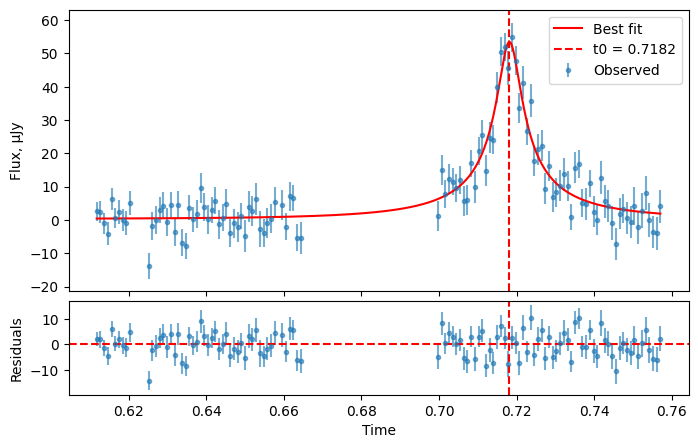

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Paczynski amplification model → converted to flux
def microlens_flux_model(t, t0, u0, tE, f_star, f_bckg):
    u = np.sqrt(u0**2 + ((t - t0) / tE)**2)
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    return f_star * A + f_bckg

t_obs = forced['jd'].to_numpy() - np.floor(forced['jd'].min())
# https://github.com/BrightTransientSurvey/ztf_forced_phot/blob/f2b43ed643f2ddcc39cfc47c3bc7649ad57e2ac5/bts_phot/calibrate_fps.py#L727
flux_obs = forced['forcediffimflux'].to_numpy() * 10**(29 - 48.6/2.5 - 0.4*forced['zpdiff'].to_numpy())
flux_err = forced['forcediffimfluxunc'].to_numpy() * 10**(29 - 48.6/2.5 - 0.4*forced['zpdiff'].to_numpy())

# Initial guess
p0 = [t_obs[np.argmax(flux_obs)], u0_fit, tE_fit, np.max(flux_obs), -np.max(flux_obs)]

# Fit the model to flux data
popt, pcov = curve_fit(
    microlens_flux_model,
    t_obs,
    flux_obs,
    sigma=flux_err,
    absolute_sigma=True,
    p0=p0,
    bounds=[(-np.inf, -np.inf, 0.0, 0.0, -np.inf), (np.inf, np.inf, np.inf, np.inf, np.inf)],
)

t0_fit, u0_fit, tE_fit, f_star_fit, f_bckg_fit = popt
perr = np.sqrt(np.diag(pcov))

# Compute model and residuals
t_ = np.linspace(t_obs.min(), t_obs.max(), 1001)
flux_fit = microlens_flux_model(t_, *popt)
residuals = flux_obs - microlens_flux_model(t_obs, *popt)

chi2 = np.sum((residuals / flux_err) ** 2)
dof = len(flux_obs) - len(popt)
chi2_red = chi2 / dof
print(f"Reduced χ² = {chi2_red:.2f}")

# Output fit results
print("Fitted parameters (with 1σ uncertainties):")
print(f"t0      = {t0_fit:.5f} ± {perr[0]:.5f}")
print(f"u0      = {u0_fit:.3f} ± {perr[1]:.3f}")
print(f"tE      = {tE_fit:.5f} ± {perr[2]:.5f}")
print(f"f_star  = {f_star_fit:.3f} ± {perr[3]:.3f}")
print(f"f_bckg  = {f_bckg_fit:.3f} ± {perr[4]:.3f}")

# Plot with residuals
fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 5),
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

# Light curve
ax1.errorbar(t_obs, flux_obs, yerr=flux_err, fmt='o', ms=3, label='Observed', alpha=0.6)
ax1.plot(t_, flux_fit, 'r-', label='Best fit')
ax1.axvline(t0_fit, color='r', linestyle='--', label=f't0 = {t0_fit:.4f}')
ax1.set_ylabel("Flux, μJy")
ax1.legend()

# Residuals
ax2.errorbar(t_obs, residuals, yerr=flux_err, fmt='o', ms=3, alpha=0.6)
ax2.axhline(0, color='r', ls='--')
ax2.axvline(t0_fit, color='r', linestyle='--')
ax2.set_xlabel("Time")
ax2.set_ylabel("Residuals")

plt.show()